In [1]:
import numpy as np
import torch
from collections import deque
from sklearn.neighbors import NearestNeighbors
class ReplayBuffer():
    def __init__(self, max_size, device, knn_k=5):
        self.max_size = max_size
        self.buffer = []
        self.rewards = []
        self.priorities = []
        self.device = device
        self.knn_k = knn_k  # KNN에서 사용할 이웃의 수
        self.reward_cutline = None

    def add(self, transition, rewards):
        transition, rewards = transition.cpu().numpy(), rewards.cpu().numpy()
        if len(self.buffer) + transition.shape[0] >= self.max_size:
            self.remove_high_density_sample(len(self.buffer)//5)
        
        for i in range(transition.shape[0]):
            if self.reward_cutline is not None and rewards[i] < self.reward_cutline:
                continue
            self.buffer.append(transition[i])
            self.rewards.append(max(rewards[i], -100))
            self.priorities.append(max(rewards[i], -100))
            if len(self.buffer) == 200000 and self.reward_cutline is None:
                self.reward_cutline = np.percentile(self.rewards, q=99)
                print("Reward cutline: ", self.reward_cutline)
                idx = np.where(np.array(self.rewards) > self.reward_cutline)[0]
                self.buffer = [self.buffer[i] for i in idx]
                self.rewards = [self.rewards[i] for i in idx]
                self.priorities = [self.priorities[i] for i in idx]

    def sample(self, batch_size):
        priorities = self.softmax(self.priorities)
        
        # Replace=False로 중복되지 않게 샘플링
        indices = np.random.choice(len(self.buffer), batch_size, p=priorities, replace=T)
        
        samples = [self.buffer[idx] for idx in indices]
        rewards  = [self.priorities[idx] for idx in indices]
        
        # Tensor로 변환 후 장치로 이동
        samples, rewards = torch.tensor(np.array(samples)).float().to(self.device), torch.tensor(np.array(rewards)).float().to(self.device)
        
        return samples, rewards
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def remove_high_density_sample(self, num_samples, return_samples=False):
        # Buffer에 있는 샘플들에 대해 KNN을 사용하여 밀도를 계산
        buffer_array = np.array(self.buffer)
        if len(buffer_array) < self.knn_k + 1:
            return  # 샘플이 너무 적으면 제거하지 않음

        nbrs = NearestNeighbors(n_neighbors=self.knn_k + 1).fit(buffer_array)
        distances, _ = nbrs.kneighbors(buffer_array)
        
        # 각 샘플의 밀도를 계산 (거리의 역수를 밀도로 간주)
        densities = 1.0 / np.sum(distances[:, 1:], axis=1)
        
        #normalized_densities = self.softmax(densities)
        #normalized_rewards = self.softmax(self.rewards)
        
        #density 높은 애들 증폭
        self.priorities = list(-np.log(densities + 1e-5))
        # Reward가 낮고, 밀도가 높은 샘플을 제거
        criteria = densities 
        high_density_low_reward_indexes = np.argsort(criteria)[-num_samples:] # argsort로 정렬시 0이 가장 작은 값이므로 -num_samples로 뒤에서부터 샘플을 뽑음
            
        if return_samples == True:
            samples = [self.buffer[i] for i in high_density_low_reward_indexes]
            return torch.tensor(np.array(samples)).float().to(self.device)
        else:
            self.buffer = [v for i, v in enumerate(self.buffer) if i not in high_density_low_reward_indexes]
            self.rewards = [v for i, v in enumerate(self.rewards) if i not in high_density_low_reward_indexes]
            self.priorities = [v for i, v in enumerate(self.priorities) if i not in high_density_low_reward_indexes]

    def __len__(self):
        return len(self.buffer)

In [17]:
import matplotlib.pyplot as plt

def check_density_removal(buffer):
    # 현재 버퍼 상태 시각화
    buffer_array = np.array(buffer.buffer)
    
    if len(buffer_array) < buffer.knn_k + 1:
        print("샘플이 너무 적어 밀도 분석을 수행할 수 없습니다.")
        return
    
    # 밀도 계산
    nbrs = NearestNeighbors(n_neighbors=buffer.knn_k + 1).fit(buffer_array)
    distances, _ = nbrs.kneighbors(buffer_array)
    densities = 1.0 / np.sum(distances[:, 1:], axis=1)
    
    # 밀도 높은 샘플 제거
    removed_samples = buffer.remove_high_density_sample(2000, return_samples=True)
    
    # 시각화: 밀도와 보상
    plt.figure(figsize=(14, 6))

    # 제거된 샘플의 밀도와 보상
    plt.subplot(1, 2, 1)
    plt.scatter(densities, buffer.rewards, label="Remaining Samples")
    removed_nbrs = NearestNeighbors(n_neighbors=buffer.knn_k + 1).fit(removed_samples.cpu().numpy())
    removed_distances, _ = removed_nbrs.kneighbors(removed_samples.cpu().numpy())
    removed_densities = 1.0 / np.sum(removed_distances[:, 1:], axis=1)
    plt.scatter(removed_densities, [-100] * len(removed_samples), color='red', label="Removed Samples")
    plt.xlabel("Density")
    plt.ylabel("Rewards")
    plt.title("Density vs Rewards")
    plt.legend()

    # 밀도 분포 시각화
    plt.subplot(1, 2, 2)
    plt.hist(densities, bins=50, alpha=0.5, label="Remaining Samples")
    plt.hist(removed_densities, bins=50, alpha=0.5, color='red', label="Removed Samples")
    plt.xlabel("Density")
    plt.ylabel("Frequency")
    plt.title("Density Distribution")
    plt.legend()

    plt.show()

    # 상관관계 분석
    correlation = np.corrcoef(densities, buffer.rewards)[0, 1]
    print(f"밀도와 보상의 상관관계: {correlation:.4f}")


In [18]:
buffer = ReplayBuffer(max_size=200000, device='cpu', knn_k=5)

In [29]:
# sample data with 0 centered gaussian with std = 0.1
# y_value proportional to the norm of x
x = np.random.randn(*x_shape) * 0.1
y = np.linalg.norm(x, axis=1)

In [30]:
# add data to buffer
buffer.add(torch.tensor(x).float(), torch.tensor(y).float())

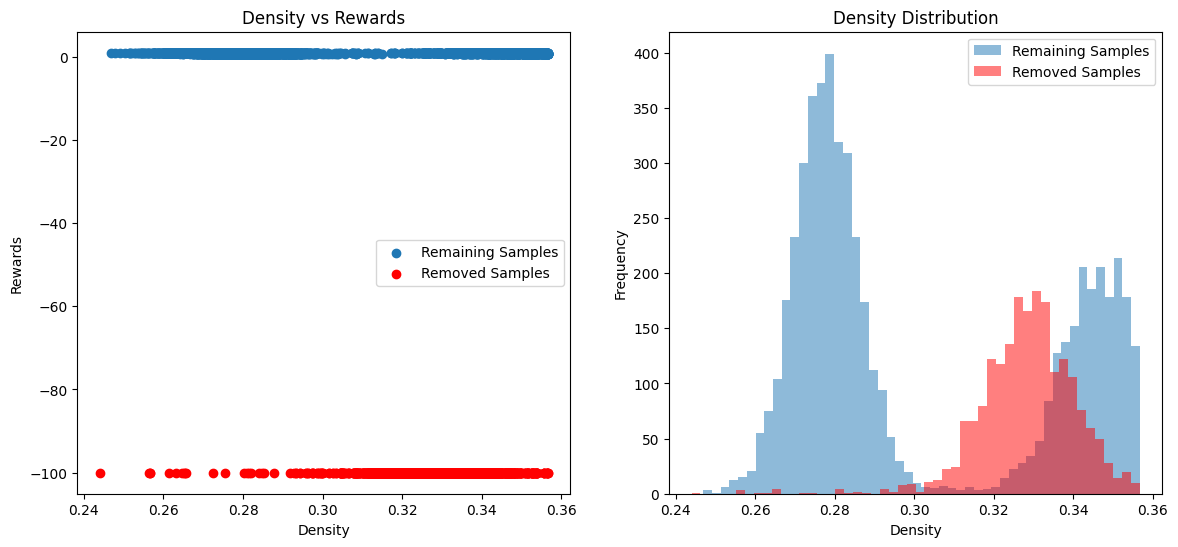

밀도와 보상의 상관관계: -0.0154


In [31]:
# check density removal
check_density_removal(buffer)